# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Oct 04, 2021 at 11:59pm**

## Table of Contents

- [Instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions <a name="si"></a>
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [2]:
census_df = pd.read_csv("adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (60%) and `test_df` (40%) with `random_state = 42`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 60%/40% split because this is kind of a big dataset for a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_

In [3]:
train_df, test_df = train_test_split(census_df, test_size = 0.4, random_state = 42)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [4]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, use the `include="all"` argument to show summary statistics of all  features.
2. Visualize the histograms of numeric features. 
3. From the visualizations, which features seem relevant for the given prediction task?

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [7]:
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


In [8]:
train_df_nan.describe(include="all")

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,19536.000000,18428,1.953600e+04,19536,19536.000000,19536,18424,19536,19536,19536,19536.000000,19536.000000,19536.000000,19187,19536
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,13570,NaN,6256,NaN,9025,2490,7937,16676,13079,NaN,NaN,NaN,17517,14841
mean,38.592547,NaN,1.892662e+05,NaN,10.084767,NaN,NaN,NaN,NaN,NaN,1090.443540,86.537162,40.532606,NaN,NaN
std,13.638971,NaN,1.049020e+05,NaN,2.580723,NaN,NaN,NaN,NaN,NaN,7449.700833,402.395668,12.406636,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.177670e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.782835e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,2.368860e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


The info() method describes the feature names, their data types, and a count of how many of them are non-null. The describe() method gives summary statistics of each of the features.

In [9]:
numeric_features = ["age", "fnlwgt", "education.num", "capital.gain", "capital.loss", "hours.per.week"]

In [10]:
X_pos = train_df_nan[train_df_nan.income == '<=50K']
X_neg = train_df_nan[train_df_nan.income == '>50K']

# Check that we got all the values
assert(X_pos.shape[0] + X_neg.shape[0] == train_df_nan.shape[0]) 

In [11]:
X_feat_pos = np.zeros([X_pos.shape[0], len(numeric_features)])
X_feat_neg = np.zeros([X_neg.shape[0], len(numeric_features)])

for j, feat in enumerate(numeric_features):
    
    X_feat_pos[:,j] = [X_pos[[feat]].iloc[i][0] for i in range(X_pos.shape[0])]
    X_feat_neg[:,j] = [X_neg[[feat]].iloc[i][0] for i in range(X_neg.shape[0])]

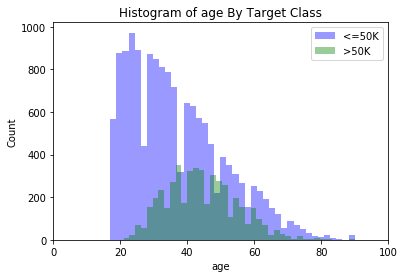

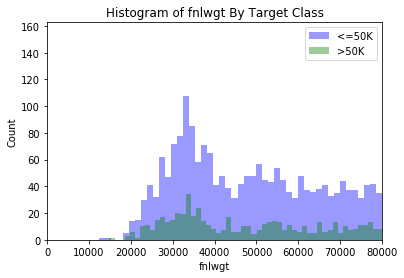

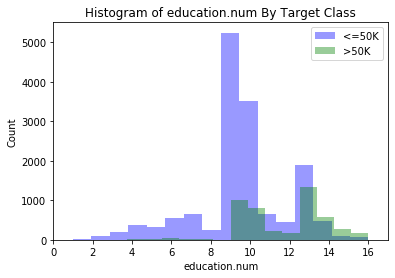

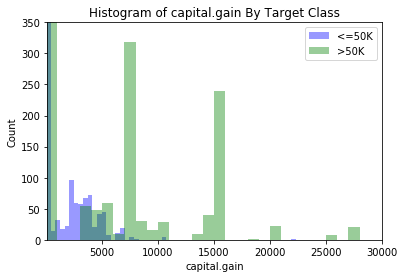

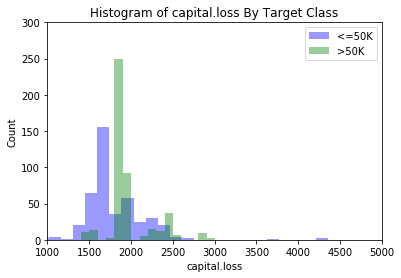

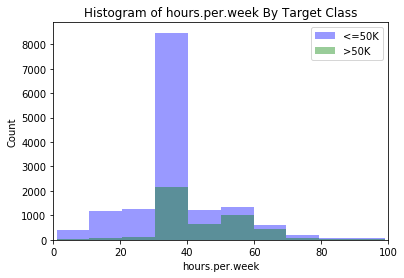

In [12]:
#Did this part in a separate loop so I could adjust
#the number of bins and x-limits in each plot without having
#to recalculate everything

bin_num = [40,1000,16,100,30,10]

#this gets rid of some of the extreme values of the data but those are rare
#and just make the plots harder to visualize properly
x_limit = [[0,100], [0,80000], [0,17], [100,30000], [1000,5000], [0,100]] 
y_limit = [None, None, None, [0,350], [0,300], None]

for j, feat in enumerate(numeric_features):
    
    plt.figure()
    plt.hist(X_feat_pos[:,j], bins = bin_num[j], color = "b", alpha = 0.4, label = "<=50K")
    plt.hist(X_feat_neg[:,j], bins = bin_num[j], color = "g", alpha = 0.4, label = ">50K")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.title("Histogram of %s By Target Class" %feat)
    plt.xlim(x_limit[j])
    plt.ylim(y_limit[j])
    plt.legend()
    
plt.show()

Important note: I decided to get rid of the $0 bins for capital gains and losses. Both <=50K and >50K earners were so plentiful in this box that it made it impossible to see the distribution of people who had a nonzero gain or loss.

Based on the histograms above, it seems that age would be the best feature for our task of classifying whether a person makes over $50k per year. This is because the distributions are obviously different (younger people tend to be paid less), and thus there is information from this feature which can be used in making our predictions.

There might also be some useful information in capital gains/losses. It looks like people who earn >50K tend to both gain more and lose more. This makes intuitive sense; people with higher salaries will have more money to invest in the stock market. 

In addition, in the hours per week plot, while both histograms may look somewhat similar, upon observation we see that the vast majority of people who make under 50k work 35-40 hours per week, while in the groups of >$50K earners, a larger proportion of them work over 40 hours per week (in other words, the green distribution is flatter while the blue one is sharper). 

Similarly, the education plot shows a sharper spike in the 9-11 range for the under 50K earners than the over 50K earners, and the the 13 bin shows a larger spike (relative to the rest of the distribution) for hte >50K earners than the <=50K earners.

<br><br>

### 2.2 Identify transformations to apply
rubric={points:18}

**Your tasks:**
1. Identify the sequence of transformations that you would apply on each column in the dataset and fill in the table below accordingly. An example of the sequence of transformations to be applied on the `occupation` feature is shown in the table below. You may decide not to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. 
2. Are there common transformations you would like to apply on certain types of features? Identify different feature types for applying different transformations. In particular, fill in the lists below. 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. 

> Note: This question is a bit open-ended and there is no single correct solution.

In [13]:
#Used these next two cells to investigate each of the features.
train_df_nan[["capital.loss"]].describe(include="all")

,capital.loss
count,19536.000000
mean,86.537162
std,402.395668
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4356.000000


In [14]:
train_df_nan[["capital.loss"]]

,capital.loss
25823,0
10274,0
27652,0
13941,0
31384,0
...,...
29802,0
5390,0
860,1887
15795,0


In [15]:
train_df_nan[["native.country"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   native.country  19187 non-null  object
dtypes: object(1)
memory usage: 305.2+ KB


| Feature | Transformation |
| --- | ----------- |
| occupation | Imputation, OHE |
| age | Scaling |
| workclass | Imputation, OHE |
| fnlwgt | Scaling |
| education | OHE |
| education.num | Scaling |
| marital.status | OHE |
| relationship | OHE |
| race | OHE |
| sex | OHE |
| capital.gain | Scaling |
| capital.loss | Scaling |
| hours.per.week | Scaling |
| native.country | Imputation, OHE |


2. ANSWER: Generally, I would do imputation on any features with missing values, scaling on any numerical features, and encoding on any categorical features.

In [16]:
# Fill in the lists below. 
# It's OK to keep some of the lists empty or add new lists.

numeric_features = ["age", "fnlwgt", "education.num", "hours.per.week"]
categorical_features = ["occupation", "workclass", "education", "marital.status", 
                       "relationship", "race", "native.country"]#I was going to make education ordinal, but it's not clear how to order masters/doctorate vs. prof school

binary_features = ["sex"] #as stated in the question this is biological sex (not gender) and as the data is presented it is binary
drop_features = [] #I would consider dropping "occupation" if there were approximately n unique values, but there are only 14.
impute_features = ["occupation", "workclass", "native.country"]
passthrough_features = ["capital.gain", "capital.loss"] #These are sparse features
target = "income"

3. ANSWER: That depends heavily on the intended use of the results. I do not think that investigating any statistic is inherently ethically wrong. For example, in my opinion it would be okay for a researcher in the social sciences to investigate whether there exists a correlation between race and salary. However, if you knew this model was going to be used by a company to aid in determining whether or not to approve a loan, that sort of decision should be based purely on financial features and not on race/gender/etc. 

<br><br>

### 2.3 Separating feature vectors and targets  
rubric={points:4}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [17]:
X_train = train_df_nan.drop(["income"], axis=1)
X_test = test_df_nan.drop(["income"], axis=1)
y_train = train_df_nan[["income"]]
y_test = test_df_nan[["income"]]

2. ANSWER: You couldn't use the SVC model on this because we haven't done any preprocessing; the scales are all different (which would lead to bad results because certain features are weighted far more heavily than others), and even worse, some features aren't numerical, and some feature values are missing entirely.

<br><br><br><br>

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. 
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? 
3. Why do we need to use a column transformer in this case? Briefly explain. 

In [18]:
imp_ohe_pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
                                OneHotEncoder(handle_unknown="ignore", dtype=int))

In [19]:
preprocessor = make_column_transformer(
    (imp_ohe_pipeline, categorical_features+impute_features), #doesn't hurt to impute features that don't necessarily need it
    (StandardScaler(), numeric_features)
)

In [20]:
X_train_trans = preprocessor.fit_transform(X_train)
X_train_trans = pd.DataFrame(X_train_trans.toarray())
print("The shape of the data is:")
X_train_trans.shape

The shape of the data is:


(19536, 164)

2. As expected, when viewing the shape we see the number of examples hasn't changed, but the number of features has increased from 14 to 164. This comes from the encoding. Every categorical features with $m$ categories has been turned into $m$ distinct features.

3. We need to use a column transformer because each column needs a unique treatment. If we simply used a pipeline, we'd be using the wrong transformers on certain columns (for example, OHE on data that's already numerical, or scaling on non-numerical data).

<br><br><br><br>

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [21]:
results_dict = {} # dictionary to store all the results

In [22]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [23]:
dc = DummyClassifier(strategy = "prior")

pipe = make_pipeline(preprocessor, dc)

results_dict["dummy"] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5)

dummy_cv = pd.DataFrame(results_dict["dummy"], columns = ["DummyClassifier"])
dummy_cv

,DummyClassifier
fit_time,1.535 (+/- 0.086)
score_time,0.044 (+/- 0.004)
test_score,0.760 (+/- 0.000)


The dummy classifier actually does fairly well, and this is probably just because the majority of people in the dataset make under \$50K.

<br><br>

### 4.2 Trying different classifiers
rubric={points:14}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [24]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

for model_name in list(models.keys()):
    
    pipe = make_pipeline(preprocessor, models[model_name])
    
    results_dict[model_name] = mean_std_cross_val_scores(pipe, X_train, np.ravel(y_train), cv=5)

In [25]:
result_df = pd.DataFrame()
for model_name in list(models.keys()):
    result_df[model_name] = results_dict[model_name]
    
result_df

,Decision Tree,kNN,RBF SVM
fit_time,2.399 (+/- 0.466),1.090 (+/- 0.126),12.403 (+/- 2.367)
score_time,0.037 (+/- 0.017),5.451 (+/- 1.175),1.570 (+/- 0.319)
test_score,0.781 (+/- 0.003),0.822 (+/- 0.006),0.836 (+/- 0.005)


The overall fastest model is the decision tree. kNN is quite fast during fit (since it's not really doing anything during fit except storing the data), and slower during prediction (since this is where it computes all the distances). While we weren't taught the details of SVM, the times do make sense; we know that unlike kNN, the majority of the time is spent during fit because that is where the support vectors are determined. Once we have the support vectors, this saves massive amounts of time during the predict phase.

As for accuracy, the decision tree is not much better than the dummy classifier. On the other hand kNN performs better, and as expected, SVM performs even better still. Of course, this is just with the default settings on each model, and no hyperparameter tuning.

<br><br>

### (optional) 4.3 Exploring importance of scaling
rubric={points:1}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

In [26]:
no_scaling_preprocessor = make_column_transformer((imp_ohe_pipeline, categorical_features+impute_features))

for model_name in list(models.keys()):
    
    pipe = make_pipeline(no_scaling_preprocessor, models[model_name])
    
    results_dict[model_name] = mean_std_cross_val_scores(pipe, X_train, np.ravel(y_train), cv=5)

In [27]:
result_no_scaling_df = pd.DataFrame()
for model_name in list(models.keys()):
    result_no_scaling_df[model_name] = results_dict[model_name]
    
result_no_scaling_df

,Decision Tree,kNN,RBF SVM
fit_time,1.157 (+/- 0.063),0.892 (+/- 0.068),9.293 (+/- 0.785)
score_time,0.021 (+/- 0.004),3.751 (+/- 0.189),1.284 (+/- 0.067)
test_score,0.817 (+/- 0.002),0.808 (+/- 0.006),0.828 (+/- 0.005)


This time, the decision tree does about the same, which makes sense because scaling doesn't affect decision trees. This is because whether the values are spread over a large interval or a small one, the splits will still be exactly the same. On the other hand, kNN and SVM both perform worse. This also makes sense, because now that there is no scaling, some features will be weighed more heavily than others simply because the distance between them is "greater" in the original unscaled units.

### 4.4 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this might take a while. 

In [28]:
param_grid = {"C": np.logspace(-2, 2, 4)}

In [29]:
for c in param_grid["C"]:
    
    pipe = make_pipeline(preprocessor, SVC(C=c))
    
    results_dict["SVM (C=%.3f)"%(c)] = mean_std_cross_val_scores(pipe, X_train, np.ravel(y_train), cv=5)

In [30]:
SVM_result_df = pd.DataFrame()
for c in param_grid["C"]:
    SVM_result_df["SVM (C=%.3f)"%(c)] = results_dict["SVM (C=%.3f)"%(c)]
    
SVM_result_df

,SVM (C=0.010),SVM (C=0.215),SVM (C=4.642),SVM (C=100.000)
fit_time,11.130 (+/- 1.163),11.339 (+/- 1.546),13.221 (+/- 1.276),29.453 (+/- 1.103)
score_time,1.810 (+/- 0.216),1.664 (+/- 0.252),1.470 (+/- 0.080),1.359 (+/- 0.015)
test_score,0.821 (+/- 0.005),0.833 (+/- 0.004),0.838 (+/- 0.004),0.814 (+/- 0.006)


The hyperparameter which seems to be performing best is $C=4.64$. It has better accuracy than the default value of $C=1$ as we saw in question 4.2, and the standard deviation of the accuracy does not change by much.

<br><br><br><br>

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:10}

**Your tasks:**

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 
3. Are the cross-validation results and test results consistent? 

In [31]:
C_best = param_grid["C"][2]

sv = SVC(C=C_best)

pipe = make_pipeline(preprocessor, sv)
pipe.fit(X_train, np.ravel(y_train))

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                      

In [32]:
accuracy = pipe.score(X_test, y_test)

In [33]:
print("Using C = %.3f, the test score of SVM is %.3f, while the cross-validation score was %s" %(C_best,accuracy,SVM_result_df.iloc[2][2]))

Using C = 4.642, the test score of SVM is 0.834, while the cross-validation score was 0.838 (+/- 0.004)


The cross validation accuracy is very similar to the test accuracy, which is very good as it indicates our approximation error is quite low. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](eva-well-done.png)

